In [7]:
import sys
import os
import util.general
import util.train_test
#import util.preprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.optim 

In [9]:
base_path = 'C:/Users/ryans/Downloads/blood-vessel-segmentation/train/'
datasets = ['kidney_1_dense/', 'kidney_1_voi/', 'kidney_2/', 'kidney_3_dense/', 'kidney_3_sparse/']
image_loader = util.general.ImageGrabber(base_path, datasets)
image_loader.load()
image_files = image_loader.image_files
label_files = image_loader.label_files

# slice some middle 10 elements of each list
image_files = image_files[1500:1510]
label_files = label_files[1500:1510]

# Train Test Split
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# Create Train/Test Datasets
train_dataset = util.general.CustomDataset(train_image_files, train_mask_files, augmentation_transforms=None)
val_dataset = util.general.CustomDataset(val_image_files, val_mask_files, augmentation_transforms=None)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True)

Skipping kidney_3_dense/ because it does not have an images subfolder.


In [10]:
# Set Dataloader
dataloaders = {
    'training': train_dataloader,
    'test': val_dataloader
}

In [ ]:
epochs = 25

def train():
    model = util.unet3d.UNetCrossBlock3D([1,2,3,4], 2)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = util.train_test.FocalLoss(gamma=2)

    trained_model, train_epoch_losses, test_epoch_losses = util.train_test.train_and_test(model, dataloaders, optimizer, criterion, num_epochs=epochs)

    return trained_model, train_epoch_losses, test_epoch_losses

trained_model, train_epoch_losses, test_epoch_losses = train()

In [13]:
# change pytorch to use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Batch 1
Image batch shape: torch.Size([1, 3, 1303, 912])
Mask batch shape: torch.Size([1, 1303, 912])


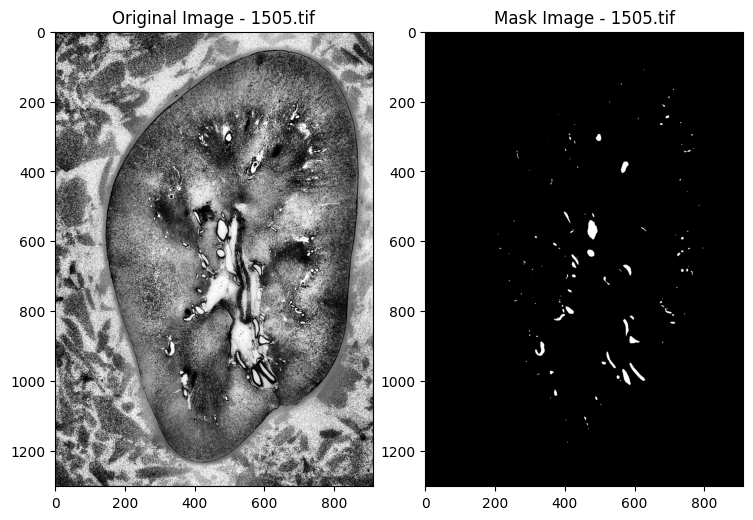

In [10]:
# Visualize Batches
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

    for image, mask, image_path, mask_path in zip(batch_images, batch_masks, train_image_files, train_mask_files):
        image = image.permute(1,2,0).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')

        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)

        plt.figure(figsize=(15,10))

        plt.subplot(2,4,1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original Image - {image_filename}")

        plt.subplot(2,4,2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask Image - {mask_filename}")

        plt.tight_layout()
        plt.show()
    break

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import ipywidgets as widgets
import torch
import util

data_folder = '/root/data/train'
sample_pth_voi = data_folder + '/kidney_3_voi'
sample_pth_dense = data_folder + '/kidney_1_dense'
sample_pth = data_folder + '/kidney_3_sparse'
sample_pth_3dense = data_folder + '/kidney_3_dense'

def normalize(image):
    image = image.astype(np.float32)
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val)
    return (image * 255).astype('uint8')

def load_sample(sample_pth):
    fns = os.listdir(sample_pth)
    slices = []
    for file in fns:
        if file.endswith('.tif'):
            slices.append(
                normalize(tiff.imread(sample_pth + '/' + file))
            )
    return torch.tensor(np.stack(slices, axis=-1))

# x_voi, y_voi = load_sample(sample_pth_voi + '/images'), load_sample(sample_pth_voi + '/labels')
# x_dense, y_dense = load_sample(sample_pth_dense + '/images'), load_sample(sample_pth_dense + '/labels')
x, y = load_sample(sample_pth + '/images'), load_sample(sample_pth + '/labels')
y_dense = load_sample(sample_pth_3dense + '/labels')

/tmp/ipykernel_6604/4130229970.py:19: RuntimeWarning: divide by zero encountered in divide
  image = (image - min_val) / (max_val - min_val)
/tmp/ipykernel_6604/4130229970.py:19: RuntimeWarning: invalid value encountered in divide
  image = (image - min_val) / (max_val - min_val)
/tmp/ipykernel_6604/4130229970.py:20: RuntimeWarning: invalid value encountered in cast
  return (image * 255).astype('uint8')


In [9]:
y_dense.shape

torch.Size([1706, 1510, 501])

In [11]:
util.Display(x)()

interactive(children=(IntSlider(value=0, description='idx_td', max=1034), Output()), _dom_classes=('widget-int…

In [10]:
util.Display(y_dense)()

interactive(children=(IntSlider(value=0, description='idx_td', max=500), Output()), _dom_classes=('widget-inte…

In [5]:
sample_pth = data_folder + '/kidney_3_sparse/images'
# sample_pth = data_folder + '/kidney_3_sparse/labels'
# sample_pth = data_folder + '/kidney_3_dense/labels'

fns = os.listdir(sample_pth)
len(fns)

1035

In [7]:
x_dense.min(), x_dense.max()

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [ ]:
win_x = x.clamp(x.mean() - x.std(), x.mean() + x.std())
win_x /= win_x.std()

In [2]:
util.Display(x_voi, y_voi)()

interactive(children=(IntSlider(value=0, description='idx_td', max=1396), Output()), _dom_classes=('widget-int…

In [3]:
util.Display(x_dense, y_dense)()

interactive(children=(IntSlider(value=0, description='idx_td', max=2278), Output()), _dom_classes=('widget-int…

In [10]:
x.shape

torch.Size([1303, 912, 2279])

In [6]:
import torch
import torch.nn as nn

model = nn.Sequential()
model.append(nn.ReLU())
x = torch.randn(1, 1, 96, 96)
model(x)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1259,  ..., 0.0000, 0.0000, 0.5195],
          ...,
          [0.3410, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.9820, 0.0000, 0.9594,  ..., 0.9998, 0.4548, 0.0000],
          [0.0000, 0.5367, 2.3359,  ..., 0.9869, 0.0000, 0.5348]]]])

In [1]:
layers = [64, 128, 256, 512, 1024]
cross_layers = layers.copy()

cross_layers[-2] = 320
layers, cross_layers

([64, 128, 256, 512, 1024], [64, 128, 256, 320, 1024])

In [1]:
import util
import torch

model = util.UNet3D()
up = torch.nn.Upsample(scale_factor=2, mode='trilinear')
# x = torch.randn(1, 320, 24, 24, 24)
x = torch.randn(1, 1, 96, 96, 96)
pred = model(x)
# up(x).shape

[tensor([[[[[ 7.7583e-02, -1.3707e-01, -8.1170e-02,  ..., -1.0404e-01,
             -1.0227e-01, -2.8171e-01],
            [ 1.7937e-01, -1.7809e-01,  7.5761e-03,  ...,  1.4582e-01,
             -9.9046e-02, -2.3409e-01],
            [ 1.0817e-01, -7.8835e-02,  8.5856e-02,  ...,  4.0768e-02,
             -3.8706e-02, -3.0009e-01],
            ...,
            [ 1.7832e-01, -6.3193e-02, -1.3432e-01,  ..., -6.3492e-02,
              7.9011e-03, -2.3347e-01],
            [ 7.2849e-01, -4.1187e-02,  1.9332e-01,  ...,  3.0611e-01,
             -1.1561e-02, -2.6163e-01],
            [-8.2680e-02, -2.4505e-01, -1.8323e-01,  ..., -2.1400e-01,
             -2.2233e-01, -1.7517e-01]],
 
           [[-1.2338e-01, -3.0468e-01, -2.9482e-01,  ..., -3.2705e-01,
             -3.3829e-01, -3.3982e-01],
            [ 1.1021e-01, -3.0933e-01, -3.2249e-01,  ..., -3.3620e-01,
             -3.2813e-01, -3.2931e-01],
            [-2.7907e-01, -3.3392e-01, -3.3935e-01,  ..., -3.3196e-01,
             -2.8611e